# Logic Gate Task

This task utilizes a simple neural network containing single n-task context layer to learn eight different logic gates.

**Note:** This experiment uses a variation of the traditional n-task model to incorporate learning between batches instead of applying gradients at the end of batches. The idea is that learning will be much faster and more stable while retaining the ability to switch on bad tasks.

In [1]:
# Import Tensorflow and Keras layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

import math
import numpy as np
import random

# Import n-task library
from ntask.atr   import AtrMovingAverage
from ntask.layer import Context
from ntask.model import NTaskModelBatchedLearning

In [2]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

## Dataset

In [3]:
gates = ["xor", "xnor", "and", "or", "nor", "nand", "custom_1", "custom_2"]

In [4]:
labels = np.array([
    [0, 1, 1, 0], # XOR
    [1, 0, 0, 1], # XNOR
    [0, 0, 0, 1], # AND
    [0, 1, 1, 1], # OR
    [1, 0, 0, 0], # NOR
    [1, 1, 1, 0], # NAND
    [1, 0, 1, 0], # Custom 1
    [0, 1, 0, 1]  # Custom 2
])

x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

## Training and Validation

Some functions to conveniently train the model by shuffling the datasets and test the results.

In [5]:
def train(model, inputs, labels, cycles, epochs, shuffle=True, show_progress=False, batch_size=None, verbose=0):
    last_index = None
    indices = list(range(len(labels)))
    
    for cycle in range(cycles):
        
        # If the previous task is repeated, swap with a random task
        if last_index == indices[0]:
            i = randrange(1, len(indices))
            indices[0], indices[i] = indices[i], indices[0]
        
        # Train on each batch in the dataset
        for i in indices:
            print(f"Current Context ({i}):", gates[i])
            model.fit(inputs, labels[i], epochs, progress=show_progress, batch_size=batch_size, verbose=verbose)
            assert i == model.layers[model.context_layers[0]].get_hot_context()
        
        # Shuffle at the end to preserver dataset order
        if shuffle:
            list_index = indices[-1]

            # Shuffle the dataset
            random.shuffle(indices)

In [6]:
def validate(model, inputs, labels, num_task_contexts):
    num_passed = 0
    for i in range(num_task_contexts):
        model.layers[model.context_layers[0]].set_hot_context(i)
        result = model(inputs)
        predicted = np.round(result).astype(int).flatten()
        try:
            print(f"Task {i}:", end=' ')
            assert (predicted == labels[i]).all(), "Failed on task:"
            print(result, "Passed")
            num_passed += 1
        except AssertionError:
            print(result, "Failed")
    print(f"{num_passed}/{num_task_contexts} ({100*num_passed//num_task_contexts}%) Learned successfully")

### Loss Function

In [7]:
def loss_fn(labels, predictions):
    return tf.keras.losses.binary_crossentropy(y_true=labels, y_pred=predictions)

### Optimizer

Adam was used here previously with a learn rate of `1e-4`. In the first experiment below, the tasks were learned only with about 75% confidence after 3,000 epochs. The plotted ATR values were also very slowly descending with significant spikes between contexts This was not really acceptable.

By upping the learning rate to `1e-2`, it was able to better learn the function to a much more acceptable degree. However, very large spikes can be seen during the first few context switches. The reason behind these spikes is not knonw just yet, but **further investigation into these is crucial**.

Finally, the switch to SGD was made. At first, a learning rate of `1e-4` was used, but this resulted in difficult task switch detection. Instead, the learning rate was increased to `1e-2`. The results were significantly more stable. The spikes that occurred in the ATR plots during initial context switching were almost completely eliminated while retaining a solid function model.

In [8]:
optimizer = tf.keras.optimizers.SGD(1e-2)

___

## Static n-task - 2 Gates (XOR, XNOR) [PASSING]

In [9]:
y_train = labels[:2]
num_task_contexts = len(y_train)

In [10]:
set_seed(5)

### Model

In [11]:
inp = Input((2,))
x = Dense(40, activation="relu")(inp)
x = Context(AtrMovingAverage(num_task_contexts, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [12]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [13]:
train(model, x_train, y_train, 3, 500, batch_size=1, verbose=0)

Current Context (0): xor
Current Context (1): xnor
Current Context (0): xor
Current Context (1): xnor
Current Context (0): xor
Current Context (1): xnor


### Model Validation

Assert that the model has learned all logic gates

In [14]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[0.00349838]
 [0.99807495]
 [0.99610007]
 [0.00429356]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.996341  ]
 [0.00291067]
 [0.00282103]
 [0.99659866]], shape=(4, 1), dtype=float32) Passed
2/2 (100%) Learned successfully


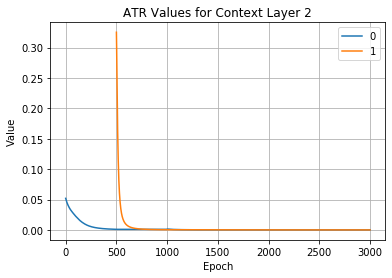

In [15]:
model.plot_atr_values()

___

## Dynamic n-task - 2 Gates (XOR, XNOR) [PASSING]

In [54]:
y_train = labels[:2]
num_task_contexts = len(y_train)

In [55]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [56]:
inp = Input((2,))
x = Dense(40, activation="relu")(inp)
x = Context(AtrMovingAverage(task_switch_threshold=-0.02, is_dynamic=True, task_add_threshold=-0.1, max_num_tasks=num_task_contexts+1))(x)
x = Dense(1, activation="sigmoid")(x)

In [57]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [58]:
train(model, x_train, y_train, 3, 500, batch_size=1, verbose=1)

Current Context (0): xor
Current Context (1): xnor
Switching... context loss: tf.Tensor(0.8987919447754125, shape=(), dtype=float64)
Best context loss... tf.Tensor(0.8987919447754125, shape=(), dtype=float64)
Task switched (added new task): 1
Current Context (0): xor
Switching... context loss: tf.Tensor(1.4194923183477393, shape=(), dtype=float64)
Task switched to: 0
Current Context (1): xnor
Switching... context loss: tf.Tensor(1.6642656497142507, shape=(), dtype=float64)
Task switched to: 1
Current Context (0): xor
Switching... context loss: tf.Tensor(1.8199222125008974, shape=(), dtype=float64)
Task switched to: 0
Current Context (1): xnor
Switching... context loss: tf.Tensor(1.9282939872719926, shape=(), dtype=float64)
Task switched to: 1


### Model Validation

Assert that the model has learned all logic gates

In [59]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[0.00349832]
 [0.998075  ]
 [0.9961    ]
 [0.00429359]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.99634105]
 [0.00291061]
 [0.00282109]
 [0.99659866]], shape=(4, 1), dtype=float32) Passed
2/2 (100%) Learned successfully


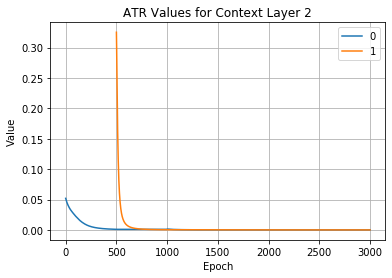

In [60]:
model.plot_atr_values()

## Static n-task - 8 Gates (XOR, XNOR, AND, OR) [PASSING]

In [61]:
y_train = labels
num_task_contexts = len(y_train)

In [62]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [63]:
inp = Input((2,))
x = Dense(128, activation="relu")(inp)
x = Context(AtrMovingAverage(num_task_contexts, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [64]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [65]:
train(model, x_train, y_train, 3, 500, shuffle=True, show_progress=False, batch_size=1, verbose=0)

Current Context (0): xor
Current Context (1): xnor
Current Context (2): and
Current Context (3): or
Current Context (4): nor
Current Context (5): nand
Current Context (6): custom_1
Current Context (7): custom_2
Current Context (6): custom_1
Current Context (3): or
Current Context (1): xnor
Current Context (0): xor
Current Context (7): custom_2
Current Context (2): and
Current Context (5): nand
Current Context (4): nor
Current Context (7): custom_2
Current Context (5): nand
Current Context (2): and
Current Context (0): xor
Current Context (1): xnor
Current Context (4): nor
Current Context (3): or
Current Context (6): custom_1


### Model Validation

Assert that the model has learned all logic gates

In [66]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[0.00350252]
 [0.99848413]
 [0.99712753]
 [0.00100303]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[9.9702334e-01]
 [8.7010860e-04]
 [1.0820925e-03]
 [9.9936128e-01]], shape=(4, 1), dtype=float32) Passed
Task 2: tf.Tensor(
[[3.0208528e-03]
 [8.9496374e-04]
 [1.0673106e-03]
 [9.9894959e-01]], shape=(4, 1), dtype=float32) Passed
Task 3: tf.Tensor(
[[2.9471517e-04]
 [9.9977422e-01]
 [9.9868751e-01]
 [9.9997365e-01]], shape=(4, 1), dtype=float32) Passed
Task 4: tf.Tensor(
[[9.97940302e-01]
 [1.22231245e-03]
 [1.32805109e-03]
 [1.02291495e-04]], shape=(4, 1), dtype=float32) Passed
Task 5: tf.Tensor(
[[0.9967357 ]
 [0.9992907 ]
 [0.9997394 ]
 [0.00119224]], shape=(4, 1), dtype=float32) Passed
Task 6: tf.Tensor(
[[9.9883759e-01]
 [5.1796436e-04]
 [9.9977994e-01]
 [1.4669597e-03]], shape=(4, 1), dtype=float32) Passed
Task 7: tf.Tensor(
[[1.0131299e-03]
 [9.9875093e-01]
 [6.6685677e-04]
 [9.9926054e-01]], shape=(4, 1), dtype=float32) Passed
8/8 (100%) Learned s

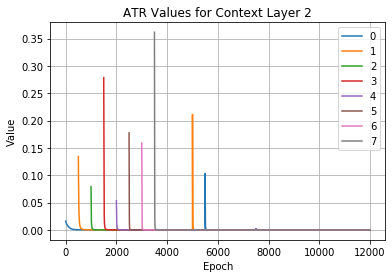

In [67]:
model.plot_atr_values()

## Dynamic n-task - 8 Gates

In [75]:
y_train = labels
num_task_contexts = len(y_train)

In [76]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [77]:
inp = Input((2,))
x = Dense(256, activation="relu")(inp)
x = Context(AtrMovingAverage(is_dynamic=True, task_switch_threshold=-0.02, task_add_threshold=-0.04, max_num_tasks=num_task_contexts+1))(x)
x = Dense(1, activation="sigmoid")(x)

In [78]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [79]:
train(model, x_train, y_train, 3, 750, shuffle=True, show_progress=False, batch_size=1, verbose=0)

Current Context (0): xor
Current Context (1): xnor
Current Context (2): and
Current Context (3): or
Current Context (4): nor
Current Context (5): nand
Current Context (6): custom_1
Current Context (7): custom_2
Current Context (6): custom_1
Current Context (3): or
Current Context (1): xnor
Current Context (0): xor
Current Context (7): custom_2
Current Context (2): and
Current Context (5): nand
Current Context (4): nor
Current Context (7): custom_2
Current Context (5): nand
Current Context (2): and
Current Context (0): xor
Current Context (1): xnor
Current Context (4): nor
Current Context (3): or
Current Context (6): custom_1


### Model Validation

Assert that the model has learned all logic gates

In [80]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[4.9206614e-04]
 [9.9906433e-01]
 [9.9886900e-01]
 [9.9930167e-04]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[9.9868798e-01]
 [5.7733059e-04]
 [4.9322844e-04]
 [9.9844128e-01]], shape=(4, 1), dtype=float32) Passed
Task 2: tf.Tensor(
[[1.5705824e-04]
 [5.9238076e-04]
 [6.4173341e-04]
 [9.9971378e-01]], shape=(4, 1), dtype=float32) Passed
Task 3: tf.Tensor(
[[5.4338574e-04]
 [9.9889731e-01]
 [9.9970543e-01]
 [9.9994361e-01]], shape=(4, 1), dtype=float32) Passed
Task 4: tf.Tensor(
[[9.9956167e-01]
 [7.1719289e-04]
 [1.0303855e-03]
 [2.1493435e-04]], shape=(4, 1), dtype=float32) Passed
Task 5: tf.Tensor(
[[9.9983132e-01]
 [9.9833989e-01]
 [9.9877018e-01]
 [4.4214725e-04]], shape=(4, 1), dtype=float32) Passed
Task 6: tf.Tensor(
[[9.9951553e-01]
 [3.5065413e-04]
 [9.9947500e-01]
 [1.1232197e-03]], shape=(4, 1), dtype=float32) Passed
Task 7: tf.Tensor(
[[4.6271086e-04]
 [9.9947912e-01]
 [2.8115511e-04]
 [9.9935329e-01]], shape=(4, 1), dtype=float32) Passed


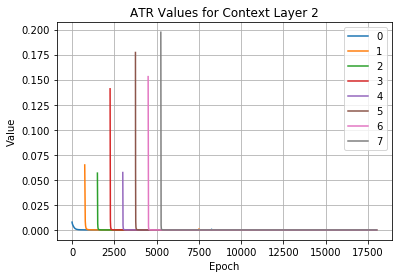

In [81]:
model.plot_atr_values()